In [1]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import time as time
import math, cmath
import sys
import auxiliary_library as me

from IPython.display import display, Math, Latex

In [2]:
### 1. armar un test que chequee que la base sea ortonormal y hermÃ­tica y que den 
       ## reales los productos. 
### 2. chequar que la semilla y la identidad no cambien en lo posible.
### 3. fijarse de agregar un coeficiente inicial a la base que acompaÃ±e a la identidad global 
### 4. 

display(Latex(f'$\\langle \\sigma^x_0 \\sigma^x_1 \\rangle^\\rho = .5 Tr \\bigg(\\rho (A^\\dagger A + A A^\\dagger)\\bigg)$')) 

<IPython.core.display.Latex object>

In [7]:
me.commutator(H_H, global_magnetization)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 0.          0.          0.          0.07853982  0.          0.
  -0.07853982  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -0.07853982]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.07853982  0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.07853982]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.07853982  0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.07853982  0.          0.         -0.07853982  0.
   0.          0.        ]]

In [36]:
N = 5
modified_HS_prod = False
basis_depth = 5

spin_ops_list = me.one_body_spin_ops(N)
globalid = spin_ops_list[0][0]
normalized_globalid = globalid/globalid.tr()

global_magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
Neel_operator = sum((-1)**(a) * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

chain_type = "XYZ"
Hamiltonian_paras = [2., .15, .2, .3]
H_H = me.Heisenberg_Hamiltonian(spin_ops_list, "XYZ", N, False, Hamiltonian_paras, True)

### Hypothesized final density state

sx0sx1 = spin_ops_list[1][0] * spin_ops_list[1][1]

if qutip.isherm(sx0sx1):
    print("Seed operator is hermitian")
else:
    print("Seed operator not hermitian")

x = .5
K = (x * sx0sx1 + (1-x) * globalid)
rhoF = K.expm()
rhoF = rhoF/rhoF.tr()
inv_rhoF = (-K).expm()
inv_rhoF = inv_rhoF/inv_rhoF.tr()

if (me.is_density_op(rhoF)):
    pass
else:
    sys.exit("rhoF is not a density op") 
    
if (me.is_density_op(inv_rhoF)):
    pass
else:
    sys.exit("inv_rhoF is not a density op") 

### Checking if the sx0sx1's rhoF-weighted average is zero:

print("<sx0sx1>_rhoF = ", (rhoF * sx0sx1).tr())

### It is not, so then I redefine it so that it has zero rhoF-weighted average

sx0sx1 = (rhoF * sx0sx1).tr() - sx0sx1

print("<new(sx0sx1)>_rhoF = ", (rhoF * sx0sx1).tr())

### Then, the seed operator has zero rhoF-weighted average and sigma=1-standard deviation.
### It's then chosen to be the seed operator

seed_op = sx0sx1
basis = []
basis.append(seed_op)
basis.append(globalid)

basis += me.recursive_basis(N, basis_depth, H_H, seed_op, rhoF)
print("At this step, the (non-orthonormal)-basis has", len(basis), "non-zero operators")

mk_basis = me.base_orth(basis, rhoF)

print("At this step, the orthonormal-basis has", len(mk_basis), "non-zero operators")

gram_matrix = me.basis_orthonormality_check(mk_basis, rhoF)

for i in range(len(mk_basis)):
    print("<rhoF * mk_basis[", i, "] > = ",(mk_basis[i] * rhoF).tr())

hij_tensor = me.H_ij_matrix(H_H, mk_basis, rhoF)[1]

Seed operator is hermitian
<sx0sx1>_rhoF =  0.031088250442899062
<new(sx0sx1)>_rhoF =  0.0
At this step, the (non-orthonormal)-basis has 7 non-zero operators
At this step, the orthonormal-basis has 6 non-zero operators
The 3 -th operator is non-hermitian 

The 4 -th operator is non-hermitian 

The 5 -th operator is non-hermitian 

Not mean-normalized operator at 1 -th level
1.4142135623730943
<rhoF * mk_basis[ 0 ] > =  0.0
<rhoF * mk_basis[ 1 ] > =  1.4142135623730943
<rhoF * mk_basis[ 2 ] > =  -6.938893903907228e-18j
<rhoF * mk_basis[ 3 ] > =  -3.0531133177191805e-16
<rhoF * mk_basis[ 4 ] > =  3.252606517456513e-17j
<rhoF * mk_basis[ 5 ] > =  -4.510281037539698e-16


In [37]:
#basis
mk_basis0_control = []
rho0 = rhoF
mk_basis0_control.append([me.HS_inner_prod(mk_basis[0], me.commutator(H_H, op2), rho0) for op2 in mk_basis])
mk_basis0_control.append([me.HS_inner_prod(mk_basis[1], me.commutator(H_H, op2), rho0) for op2 in mk_basis])
mk_basis0_control.append([me.HS_inner_prod(mk_basis[2], me.commutator(H_H, op2), rho0) for op2 in mk_basis])
mk_basis0_control.append( [me.HS_inner_prod(mk_basis[3], me.commutator(H_H, op2), rho0) for op2 in mk_basis])
mk_basis0_control.append([me.HS_inner_prod(mk_basis[4], me.commutator(H_H, op2), rho0) for op2 in mk_basis])
mk_basis0_control.append( [me.HS_inner_prod(mk_basis[5], me.commutator(H_H, op2), rho0) for op2 in mk_basis])

In [38]:
qutip.Qobj(mk_basis0_control)

Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = False
Qobj data =
[[ 4.85722573e-17+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00-1.37872587e+00j -1.07120670e-01+0.00000000e+00j
   0.00000000e+00+6.63775178e-03j -4.05038125e-02+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+1.72789888e-01j  1.34249810e-02+0.00000000e+00j
   0.00000000e+00-8.31881388e-04j  5.07617170e-03+0.00000000e+00j]
 [ 0.00000000e+00+1.40038089e+00j  0.00000000e+00+0.00000000e+00j
   3.63706746e-01+0.00000000e+00j  0.00000000e+00+4.68118710e+00j
  -1.29757316e-15+0.00000000e+00j  0.00000000e+00-4.11449068e-04j]
 [-2.63677968e-16+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00-4.68118710e+00j  3.04800051e-02+0.00000000e+00j
   0.00000000e+00+6.36172461e+00j -1.73902019e-02+0.00000000e+00j]
 [ 0.00000000e+00-1.00787434e-15j  0.00000000e+00+0.00000000e+00j
  -1.13103971e-15+0.00000000e+00j  0.00000000e+

In [39]:
qutip.Qobj(np.real(hij_tensor))

Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = False
Qobj data =
[[ 4.85722573e-17  0.00000000e+00  0.00000000e+00 -1.07120670e-01
   0.00000000e+00 -4.05038125e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.34249810e-02
   0.00000000e+00  5.07617170e-03]
 [ 0.00000000e+00  0.00000000e+00  3.63706746e-01  0.00000000e+00
  -1.29757316e-15  0.00000000e+00]
 [-2.63677968e-16  0.00000000e+00  0.00000000e+00  3.04800051e-02
   0.00000000e+00 -1.73902019e-02]
 [ 0.00000000e+00  0.00000000e+00 -1.13103971e-15  0.00000000e+00
   2.13060103e-01  0.00000000e+00]
 [-3.60822483e-16  0.00000000e+00  0.00000000e+00  1.70696790e-15
   0.00000000e+00 -5.18558381e-01]]

In [40]:
real_hij_tensor = (np.real(hij_tensor))

In [41]:
from scipy.integrate import odeint

def F(y, t, H_tensor):
    return H_tensor.dot(y)

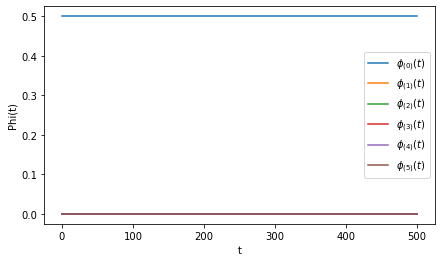

In [42]:
from scipy.integrate import ode

zero_list = [0 for i in range(len(mk_basis) - 1)]
Phi0_vec = [.5] + zero_list

t0 = 0
ts1 = np.linspace(0, 500, 200)

result = odeint(func=F, y0=Phi0_vec,t=ts1,args=(real_hij_tensor,))
plt.figure(figsize=(7, 4))

for i in range(len(mk_basis)):
    plt.plot(ts1, result[:,i], label=r'$\phi_{(%d)}(t)$'%i)

plt.xlabel("t")
plt.ylabel("Phi(t)")
plt.legend()

#r = ode(F).set_integrator('zvode', method='bdf', with_jacobian=None)
#r.set_initial_value(Phi0_vec, t0).set_f_params(2.0).set_jac_params(2.0)

#t1 = 10
#dt = 1

#while r.successful() and r.t < t1:
#    r.integrate(r.t+dt)
#    print(r.t, r.y)

In [55]:
result[:,0][0]

0.5

In [52]:
rhos_at_timet = []

for i in range(len(result)):
    loc_K = sum([result[:,i][a] * mk_basis[a] for a in range(len(mk_basis))])
    rhos_at_timet.append(loc_K.expm())
    loc_K = 0

IndexError: index 6 is out of bounds for axis 1 with size 6

In [114]:
for i in range(len(rhos_at_timet)):
    if (me.is_density_op(rhos_at_timet[i])):
        print("At time =", i, "density op")
    else:
        pass
        #print("At time =", i, "not density op")

At time = 0 density op


In [7]:
def bures(rho, sigma):
    if (me.is_density_op(rho) and me.is_density_op(sigma)):
        val1 = abs((me.sqrtM(rho)*me.sqrtM(sigma)).tr())
        val1 = max(min(val1,1.),-1.)
        val1 = np.arccos(val1)/np.pi
    else: 
        sys.exit("Singular input matrix")
    return val1

rho1 = (.4*Sx0Sx1).expm()
rho1 = rho1/rho1.tr()
bures(rho0, rho1)

0.007759750761890424

In [9]:
bures_distance_list = [bures(rho0, resultsB["State ev"][a]) for a in range(len(resultsB["State ev"]))]

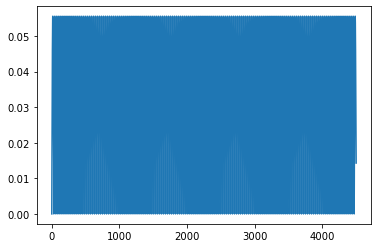

In [10]:
plt.plot(bures_distance_list)

In [8]:
bures(rho0, resultsB["State ev"][4499])

0.01428582964910818

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.125     +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        -0.00721345j
  0.03061483+0.2019766j  0.        +0.j        ]
 [0.        +0.j         0.125     +0.j         0.        +0.j
  0.        +0.j         0.        +0.00721345j 0.        +0.j
  0.        +0.j         0.03061483+0.18274073j]
 [0.        +0.j         0.        +0.j         0.125     +0.j
  0.        +0.j         0.03061483-0.00961793j 0.        +0.j
  0.        +0.j         0.        +0.00721345j]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.125     +0.j         0.        +0.j         0.03061483+0.00961793j
  0.        -0.00721345j 0.        +0.j        ]
 [0.        +0.j         0.        -0.00721345j 0.03061483+0.00961793j
  0.        +0.j         0.125     +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]

Processing custom initial state
Processing default observable basis
sampling: 30
Open evolution chosen
--- 52.11599588394165 seconds ---


IndexError: index 5 is out of bounds for axis 1 with size 5

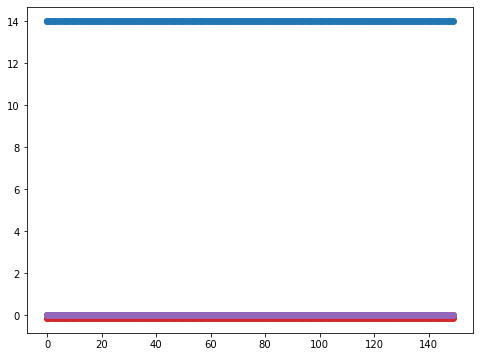

In [73]:
start_time = time.time()
unitary_ev = False; gamma = 3*np.pi**-1
size = N; gaussian = True; gr = 2; xng = .7

spin_ops_list = me.one_body_spin_ops(size)
seed_op1 = Mz = sum(spin_ops_list[3][i] for i in range(size))
seed_op2 = Sx0Sx1 = spin_ops_list[1][0]*spin_ops_list[1][0+1] + spin_ops_list[1][1]*spin_ops_list[1][0] 

NN_interactions_on_x = [spin_ops_list[1][a]*spin_ops_list[1][a+1] for a in range(N-1)] 
NN_interactions_on_x + [spin_ops_list[1][N-1]*spin_ops_list[1][0]] 

obs_basis = spin_ops_list[2]
#NN_interactions_on_x

rho0 = (.5 * qutip.tensor([qutip.qeye(2) for k in range(N)]) + .5*seed_op2).expm()
rho0 = rho0/rho0.tr()

Hamiltonian_paras = [.75, .65, .5, 1.]

chain_type = "XXZ"

title, ev_paras, resultsB = me.spin_chain_ev(size = size, init_state = rho0, chain_type = chain_type, 
                                             Hamiltonian_paras = Hamiltonian_paras, omega_1=3., omega_2=3., 
                                             temp=1, tmax = 150, deltat = 1, two_body_basis = True, 
                                             unitary_ev = unitary_ev, gamma = gamma, gaussian = gaussian, 
                                             gr = gr, xng = xng, obs_basis = None, do_project = False)

print("--- %s seconds ---" % (time.time() - start_time))

ev_paras["Time elapsed"] = time.time() - start_time

plt.figure(figsize=(8, 6))
plot_labels = ["Sx0Sx1 ", "Sx1Sx2 ", "Sx2Sx3 ", "Sx3Sx0 "]

for n in range(N-1):
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n]) #label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

In [ ]:
<O>(t)

d/dt <O> = <[H,O]>
d/dt <[H,O]> = <[H, [H,O]]>
d/dt <[H,[H,O]]> = <[H, [H,[H,O]]>
